# **Part 2**


1. Implementation of **LoG blob detection algorithm** to detect flowers in the given flowers.png picture. This part also includes comparison between the method implemented from scratch and the one provided by OpenCV library.
2. Implementation of LoG with **normalized scale variations**. [A multiscale Laplacian of Gaussian(LoG) filtering approach to pulmonary nodule detection from
whole-lung CT scans](https://arxiv.org/pdf/1907.08328.pdf)
3. Performance of additional experiments with different **threshold values** for both algorithms.



In [1]:
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np

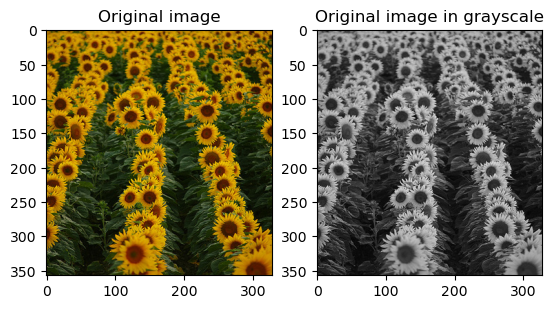

In [2]:
input_image = cv2.imread("../images/flowers.png")
image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

# since given image is in .png format it was decided to use cv2 to read it, due to the fact that it
# removes 4th bin (alpha) that is taken into account if using skimage, for instance
# step with transforming image to rgb was made due to the fact that by default cv2 reads images in bgr - it was important to put colo channels back in place
# for LoG it is better to work with 1 parameter that would correspond to color (pixel intensity or color intensity), due to the fact that it explicitly works with intensity change and min-max response, that's why original image was converted into gray scale for experiments

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_rgb)
ax1.set_title("Original image")
ax2.imshow(image_gray, cmap='gray')
ax2.set_title("Original image in grayscale")
plt.show()

$$
LoG(x,y) = -\frac{1}{\pi \sigma^4} \left [1 - \frac{x^2 + y^2}{2 \sigma^2} \right] \exp^{- \frac{x^2 + y^2}{2 \sigma^2}}
$$

In [56]:
def create_normalized_log_kernel(sigma = 1.0):
    # Step 1: Creating normalized LoG filter/kernel template
    # calculating LoG kernel - mix of gaussian smoothing and laplacian second derivative to obtain kernel for convolving with the image in one step
    # main difference between this approach and the one without normalization is additional multiplier - np.square(sigma)
    # It  is necessary to eliminate the effect of decreasing spatial derivatives with the increase of scale (sigma)
    kernel_size = np.ceil(sigma * 6).astype(int)
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma ** 4)) *
                    np.array([
                     - (2.0 * sigma ** 2) + (x - (kernel_size//2)) ** 2 + (y - (kernel_size//2)) ** 2
                    ]) *
                    np.exp(-(((x - (kernel_size//2)) ** 2 + (y - (kernel_size//2)) ** 2)) / (2.0 * sigma ** 2)),
        (kernel_size, kernel_size)
    )
    return (kernel).squeeze()
    

In [57]:
def convolve_image_with_log(image, conv_number = 6, sigma = 1.0, step_size = 1.27):
    # Step 2: Performing convolution
    # to be able to capture blos of different sizes it is important to perform convolutions with multiple filters, because the value of maximum response will never reach its peak, until the diameter of blob perfectly matches the object of interest
    # for this reason it is important to try multiple kernels - to enhance blob detection
    # in this case to try to approach reasonable set of values I decided to go with 6 convolutions
    convolved_image = np.zeros_like(image)
    convolved_images = []
    # based on the selected reference paper I picked step size of 1.27 and update function for sigma - sigma_i+1 = sigma_i * k
    for i in range(0, conv_number):
        filter = create_normalized_log_kernel(sigma)
        # convolving image with generated kernel
        convolved_image = cv2.filter2D(image, -1, filter)
        convolved_image = np.square(convolved_image)
        convolved_images.append(convolved_image)
        sigma = step_size * sigma
    return np.array([i for i in convolved_images])

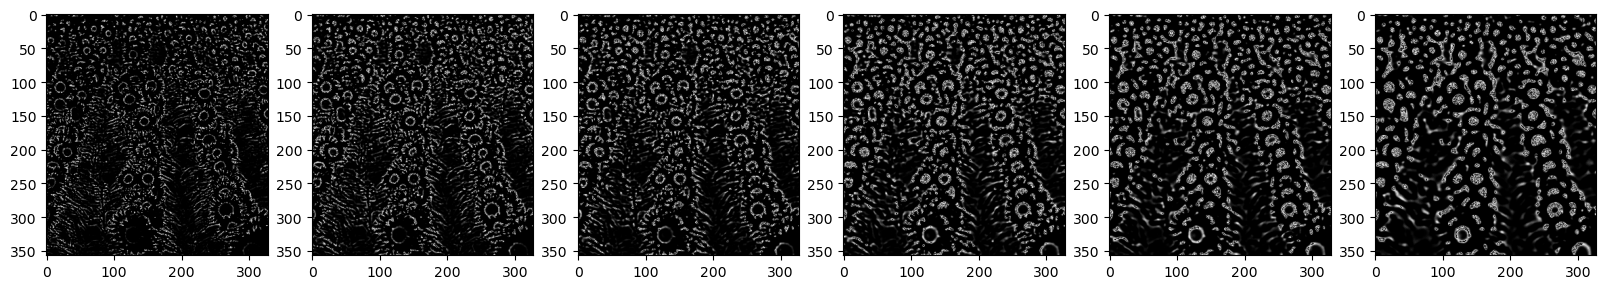

In [58]:
# plot the log images
fig, axs = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axs[i].imshow(convolve_image_with_log(image_gray)[i], cmap='gray')
    

In [59]:
def normalized_log_gray(image, sigma = 1.0, threshold = 0.03, conv_number = 6, step_size = 1.27):
    image = image/255.0
    convolved_images = convolve_image_with_log(image, conv_number, sigma, step_size)
    
    # Step 3: Finding local maximas This step finds local maxima in N-dimensional (conv_number) search space with respect to both location and scale.
    height, width = image.shape
    # here we will be finding the coordinates of the local maximas with respect to pixel positions (h - height, w - width) and dimension (n - which is one of the responses of te convolved image)
    maximums = [] 
    for i in range(1, height):
        for j in range(1, width):
            tile = convolved_images[:, i-1 : i+2, j-1 : j+2] 
            maximum = np.amax(tile)
            # threshold is important because for each pixel there will be a maximum, but not all of the pixels them contribute to blobs
            if maximum >= threshold:
                # dimension will help with finding exact sigma that was used to define that kernel and blob sizes targeted
                dimension , x_coord, y_coordinate = np.unravel_index(tile.argmax(),tile.shape)
                # each point is (original coordinte x, original coordinate y, radius size)
                maximums.append((i+x_coord-1, j+y_coordinate-1, sigma * np.power(step_size, dimension))) #finding co-rdinates
    
    maximums = list(set(maximums))       
    
    return maximums


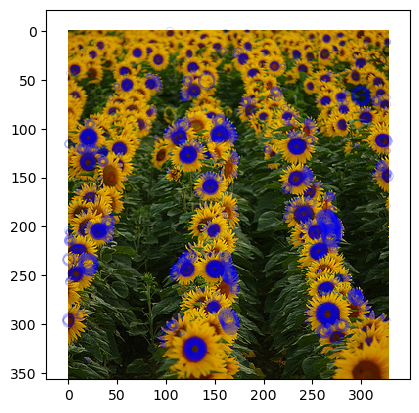

In [60]:
blobs = normalized_log_gray(image_gray, sigma=1.4, step_size=np.sqrt(2))

# Step 4: Drawing blobs

fig, ax = plt.subplots()

ax.imshow(image_rgb, interpolation='nearest')
for blob in blobs:
    y, x, radius = blob
    circle = plt.Circle((x, y), radius, color='blue', linewidth=0.1, fill=False)
    ax.add_patch(circle)
ax.plot()
plt.show()